In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import jax
import optax
import jaxopt
from flax import linen as nn
from jax import numpy as jnp
from flax.training import train_state  # Useful dataclass to keep train state
import flax

from functools import partial
import pickle

from numerical_methods import physics

In [2]:
dx, dy = 0.5, 0.5
ny, nx = 26, 49
dt=0.01

## Flow time of each time step

In [3]:
TIMES = jnp.load("dataset/times.npy")
TIMES

Array([4.0e-01, 8.0e-01, 1.2e+00, 1.6e+00, 2.0e+00, 1.0e+01, 2.0e+01,
       3.0e+01, 4.0e+01, 5.0e+01, 6.0e+01, 1.2e+02, 1.8e+02, 2.4e+02,
       3.0e+02, 3.6e+02, 4.2e+02, 4.8e+02, 5.4e+02, 6.0e+02, 6.6e+02,
       7.2e+02, 7.8e+02, 8.4e+02], dtype=float64)

## Physical Setup

Text(0.5, 1.0, 'TERRAIN')

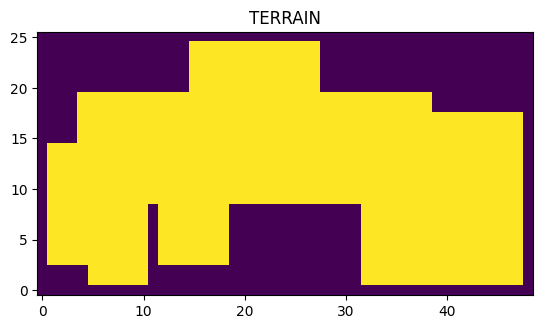

In [4]:
TERRAIN = jnp.load("dataset/terrain.npy")
plt.imshow(TERRAIN, origin='lower')
plt.title("TERRAIN")

In [5]:
INFLOW_LOCS = jnp.load("dataset/inflow_locations.npy")
INFLOW_LOCS

Array([[ 6,  8],
       [ 6, 15],
       [13, 40],
       [13, 20]], dtype=int64)

In [6]:
rel_loc = [(0, -1), (0, 0), (1, -1), (1, 0)]
INFLOW_COEFFS = jnp.load("dataset/inflow_poly_coeffs.npy")
INFLOW_COEFFS.shape

(4, 4, 25)

In [7]:
TRAIN_SET = jnp.load("dataset/train_smoke_grid.npy")
# 5 inflow locations, 24 time steps, 26x49 grid
TRAIN_SET.shape

(4, 24, 26, 49)

In [8]:
VELOCITY = jnp.load("dataset/velocity_2d.npy")
VELOCITY.shape

(2, 26, 49)

In [9]:
train_set_idx = []
for i in range(len(TRAIN_SET)):
    for j in range(len(TIMES)-1):
        train_set_idx.append((i,j))

## Simulation Function

In [26]:
@jax.jit
def conv_diff_single_step(params,
                          smoke_initial: jnp.array,
                          velocity: jnp.array,
                          time_curr: float,
                          inflow_loc: jnp.array,
                          inflow_poly_coeffs: jnp.array,
                          terrain: jnp.array,
                          dt: float):
    # set smoke at inflow locations
    y,x = inflow_loc
    for i in range(len(rel_loc)):
        rel_y, rel_x = rel_loc[i]
        c = jnp.polyval(inflow_poly_coeffs[i], time_curr)
        smoke_initial = smoke_initial.at[y+rel_y, x+rel_x].set(c)
    
    advection_term = physics.advect_corr_fvm(field=smoke_initial, 
                                             velocity=velocity,
                                             u_corr=params['u_corr'],
                                             v_corr=params['v_corr'], 
                                             dx=dx, 
                                             dy=dy) * dt
    
    diffusion_term = physics.diffuse_2d_fvm(field=smoke_initial, 
                                            diffusivity_x=params['diffusivity_x'],
                                            diffusivity_y=params['diffusivity_y'],
                                            dx=dx, 
                                            dy=dy) * dt
    smoke_pred = smoke_initial\
                    + advection_term\
                    + diffusion_term
    
    time_next = time_curr + dt
    for i in range(len(rel_loc)):
        rel_y, rel_x = rel_loc[i]
        c = jnp.polyval(inflow_poly_coeffs[i], time_next)
        smoke_pred = smoke_pred.at[y+rel_y, x+rel_x].set(c)
    
    smoke_pred = smoke_pred * terrain
    smoke_pred = jnp.maximum(smoke_pred, 0.0)
    return (smoke_pred, time_next, params, inflow_loc, inflow_poly_coeffs), None

step_for_loop = lambda carry, x: conv_diff_single_step(params=carry[2],
                                                        smoke_initial=carry[0],
                                                        velocity=VELOCITY,
                                                        time_curr=carry[1],
                                                        inflow_loc=carry[3],
                                                        inflow_poly_coeffs=carry[4],
                                                        terrain=TERRAIN,
                                                        dt=dt)

@partial(jax.jit, static_argnames=['nsteps'])
def conv_diff_nsteps(params, smoke_initial: jnp.array, time_initial, inflow_loc, inflow_poly_coeffs,nsteps):
    (smoke_pred, _, _, _, _), _ = jax.lax.scan(step_for_loop, (smoke_initial, time_initial, params, inflow_loc, inflow_poly_coeffs), xs=None, length=nsteps)
    return smoke_pred

## Training

In [32]:
def create_train_state(diffusivity_x, diffusivity_y, u_corr, v_corr, learning_rate):
    params = {}
    params['diffusivity_x'] = diffusivity_x
    params['diffusivity_y'] = diffusivity_y
    params['u_corr'] = u_corr
    params['v_corr'] = v_corr
  
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=conv_diff_nsteps,
                                         params=params,
                                         tx=tx)

@partial(jax.jit, static_argnames=['nsteps'])
def train_step(state, 
                smoke_initial,
                time_initial,
                inflow_loc,
                inflow_poly_coeffs,
                nsteps, 
                smoke_target):
  
    def loss_fn(params):
        smoke_predicted = state.apply_fn(params, 
                                         smoke_initial=smoke_initial, 
                                         time_initial=time_initial, 
                                         inflow_loc=inflow_loc, 
                                         inflow_poly_coeffs=inflow_poly_coeffs,
                                         nsteps=nsteps)
        
        # L2 loss
        # loss = jnp.sum(optax.l2_loss(smoke_predicted, smoke_target))
        # cosine loss
        # loss = 1 - jnp.sum(smoke_predicted * smoke_target)/jnp.sqrt(jnp.sum(smoke_predicted**2)*jnp.sum(smoke_target**2))
        # relative loss
        # denom = jnp.maximum(smoke_predicted, smoke_target)
        # denom = jnp.where(denom<1e-8, 1.0, denom)
        # loss = jnp.mean(optax.l2_loss(smoke_predicted, smoke_target)/denom**2)
        # new relative loss
        denom = smoke_predicted
        denom = jnp.where(denom<1e-8, 1.0, denom)
        loss = jnp.mean(optax.l2_loss(smoke_predicted, smoke_target)/denom**2)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)

    ## gradient clipping
    clipper = optax.clip_by_global_norm(1.)
    clip_state = clipper.init(grads)
    new_grads, clip_state = clipper.update(grads, clip_state)

    state = state.apply_gradients(grads=new_grads)
    state.params["diffusivity_x"] = jnp.maximum(state.params["diffusivity_x"], 0.0)
    state.params["diffusivity_y"] = jnp.maximum(state.params["diffusivity_y"], 0.0)
    return state, loss

In [33]:
####################
#Using LR scheduler#
####################

max_epoch = 30
itr_per_epoch = (len(TIMES)-1) * len(TRAIN_SET)
max_iter = itr_per_epoch * max_epoch

# optimizer: ADAM learning rate scheduler
init_lr = 1e-4
peak_lr = 1e-3
lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=init_lr, 
                                                  peak_value=peak_lr, 
                                                  warmup_steps=int(max_iter*.5),
                                                  decay_steps=max_iter, 
                                                  end_value=1e-4)
####################
#Using LR scheduler#
####################

state = create_train_state(diffusivity_x=jnp.zeros((ny,nx-1)),
                           diffusivity_y=jnp.zeros((ny-1,nx)),
                           u_corr=jnp.zeros((ny,nx-1)),
                           v_corr=jnp.zeros((ny-1,nx)),
                           learning_rate=1e-3)

In [34]:
EPOCHS = 100

losses = []
min_loss = float('inf')

order = train_set_idx
np.random.seed(0)

for epoch in range(EPOCHS):
    random.shuffle(order)
    epoch_loss = 0.0
    for i in range(len(order)):
        smoke_set_idx, times_idx = order[i]

        nsteps = int((TIMES[times_idx+1]-TIMES[times_idx]+1e-3)/dt)
        
        state, loss = train_step(state, 
                                smoke_initial=TRAIN_SET[smoke_set_idx][times_idx],
                                time_initial=TIMES[times_idx],
                                inflow_loc=INFLOW_LOCS[smoke_set_idx],
                                inflow_poly_coeffs=INFLOW_COEFFS[smoke_set_idx],
                                nsteps=nsteps, 
                                smoke_target=TRAIN_SET[smoke_set_idx][times_idx+1])
        
        print(f"EPOCH {epoch}, iteration {i}, starting from {order[i]} loss={loss}")
        epoch_loss += loss
    
    if epoch_loss < min_loss:
        state_dict = flax.serialization.to_state_dict(state)
        # v1: training diffusivity+velocity only, with inflow given only as a location
        # v1_1: lr 1e-4 adam l2 loss
        # v1_2: lr 1e-5 adam l2 loss
        # v1_3: lrscheduler adam l2 loss
        # v1_4: lr 1e-3 sgd l2 loss
        # v1_5: lr 1e-4 adam cosine loss
        # v1_6: lr 1e-4 adam, randomly initialized
        # v1_7: lr 1e-4 adam, randomly initialized only diffusivity, normal distribution 0.2
        # v1_8: lr scheduler, using relative loss
        # v2: training diffusivity+velocity, 0.01s time steps
        # v2_1: all time steps
        # v2_2: lr 1e-4 adam, using relative error
        # v2_3: corrected relative error/nsteps
        # v2_4: corrected relative errors without /nsteps
        with open('v2_4_phase1_diffusivity_min.pickle', 'wb') as handle:
            pickle.dump(state_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        np.save("v2_4_phase1_loss_min", losses)
        min_loss = epoch_loss
        print("New minimum achieved")
        
    losses.append(epoch_loss)
    print(f"EPOCH {epoch}: loss={epoch_loss}")

EPOCH 0, iteration 0, starting from (0, 11) loss=107.85161514493754
EPOCH 0, iteration 1, starting from (0, 22) loss=136.80922115356603
EPOCH 0, iteration 2, starting from (3, 4) loss=0.3603855885382152
EPOCH 0, iteration 3, starting from (0, 18) loss=127.8553854118571
EPOCH 0, iteration 4, starting from (0, 14) loss=6.625933123645951
EPOCH 0, iteration 5, starting from (3, 17) loss=2.33919399129969
EPOCH 0, iteration 6, starting from (2, 4) loss=5.449064889833644
EPOCH 0, iteration 7, starting from (2, 6) loss=1.545780560951333
EPOCH 0, iteration 8, starting from (2, 18) loss=133.67883241409737
EPOCH 0, iteration 9, starting from (1, 2) loss=0.0025657962749046546
EPOCH 0, iteration 10, starting from (3, 18) loss=7.794767549972821
EPOCH 0, iteration 11, starting from (2, 20) loss=12.485649957344268
EPOCH 0, iteration 12, starting from (2, 17) loss=0.6801836071194748
EPOCH 0, iteration 13, starting from (2, 16) loss=5.343641331834257
EPOCH 0, iteration 14, starting from (2, 3) loss=0.00

In [35]:
# v1: training diffusivity only, with inflow given only as a location
with open('v2_4_phase1_diffusivity_final.pickle', 'wb') as handle:
    pickle.dump(state_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
np.save("v2_4_phase1_loss_final", losses)

## Results

Text(0, 0.5, 'Loss')

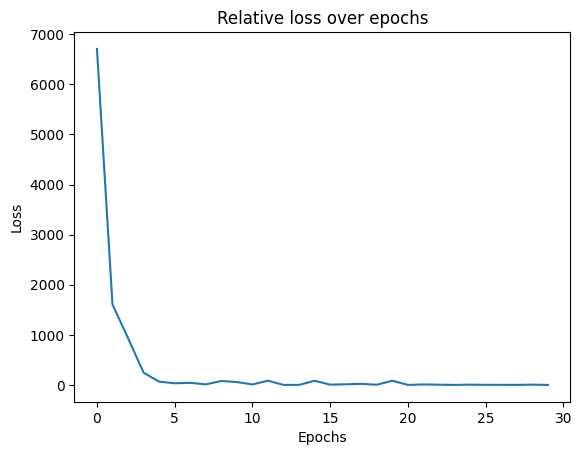

In [24]:
plt.plot(losses)
plt.title("Relative loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [49]:
state = create_train_state(diffusivity_x=jnp.zeros((ny,nx-1)),
                           diffusivity_y=jnp.zeros((ny-1,nx)),
                           u_corr=jnp.zeros((ny,nx-1)),
                           v_corr=jnp.zeros((ny-1,nx)),
                           learning_rate=1e-4)

with open('v2_2_phase1_diffusivity_min.pickle', 'rb') as bunch:
    state_dict = pickle.load(bunch)

state = flax.serialization.from_state_dict(state, state_dict)

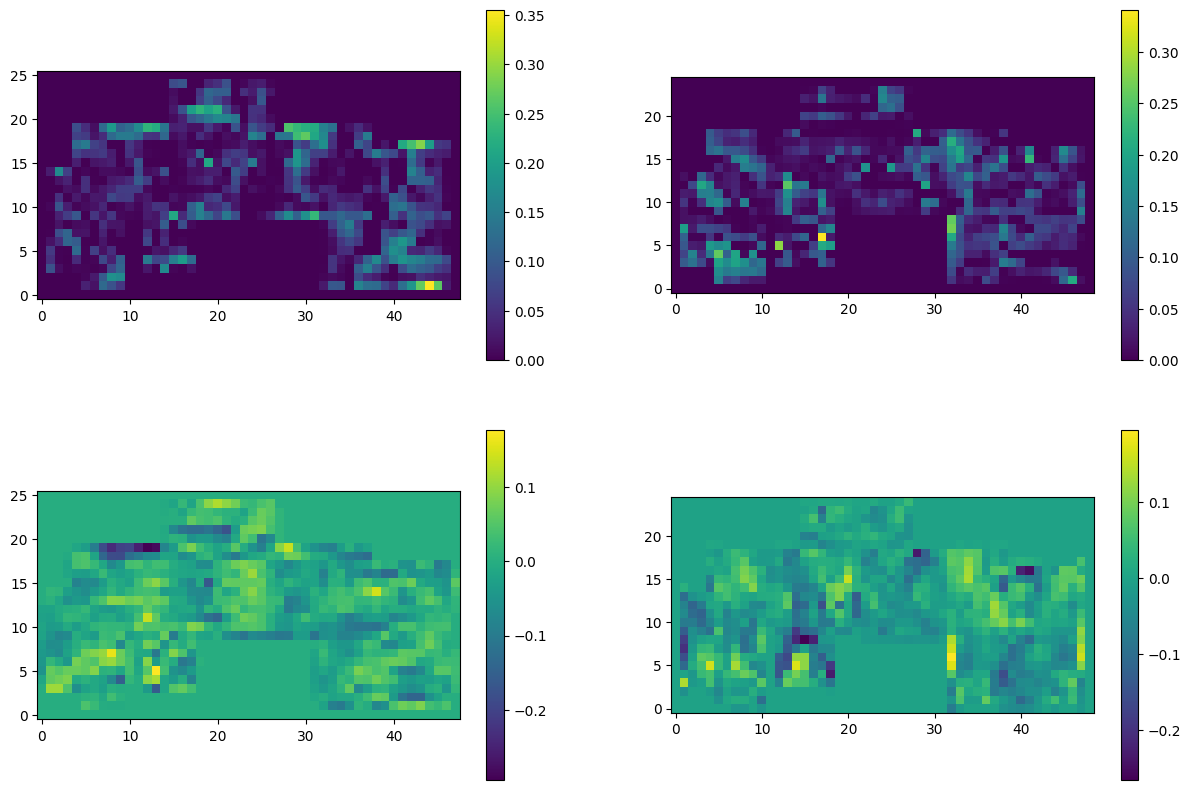

In [31]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,2,1)
plt.imshow(state.params['diffusivity_x'], origin='lower')
plt.colorbar()
fig.add_subplot(2,2,2)
plt.imshow(state.params['diffusivity_y'], origin='lower')
plt.colorbar()
fig.add_subplot(2,2,3)
plt.imshow(state.params['u_corr'], origin='lower')
plt.colorbar()
fig.add_subplot(2,2,4)
plt.imshow(state.params['v_corr'], origin='lower')
plt.colorbar()